## **Project 4**

## Superdense Coding
In quantum information, there are various measures and methods to compare the amount of information that can be stored or transmitted using qubits and how that compares to classical bits. While these are far outside the scope of an introductory course, a proof of concept depicting an enhancement facilitated by quantum entanglement should be simple enough to see. Superdense coding (sometimes also called dense coding) is one such example. It is also very closely related to quantum teleportation. The protocol is detailed below.

Using superdense coding, two parties (Alice and Bob) who share an entangled Bell pair, can transmit two classical bits worth of information by sending only one qubit from the sender to the recipient. The important part here is really the Bell pair as this protocol does not work without it. In the case presented below, Alice is the sender and Bob is the recipient. 


In [4]:
# importing standard python and Qiskit libraries

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
from qiskit.visualization import *
from qiskit.quantum_info import *

basis_gates = ['id', 'x', 'y', 'z', 's', 't', 'sdg', 'tdg', 'h', 'p', 'sx' ,'r', 'rx', 'ry', 'rz', 'u', 'u1', 'u2', 'u3', 'cx', 'barrier', 'measure', 'snapshot']

### Protocol:

1. Alice prepares a Bell state $|B_{00}\rangle$ and transmits the second qubit to Bob. (Note that no 'information' has been encoded or sent yet).
2. **The Encoding Step:** Alice encodes two classical bits of information into her qubit (one of the Bell pair qubits) by performing only single-qubit operations.
3. Alice then sends her qubit to Bob.
4. **The Decoding Step:** Bob measures both the qubits and gets both of Alice's encoded bits as the measurement outcome.

In this problem, we will _simulate_ superdense coding in the framework of quantum computing. Because of this, it is not possible to send any qubits anywhere, so we will have to pretend those parts are happening. We will imagine that Alice prepares the Bell pair and sends the second qubit to Bob. As we mentioned before, no information has been sent yet because if Bob measures his qubit now, he will measure equal outcomes in any basis he chooses to measure in. Alice then perform her encoding operations only on the first qubit. Our understanding will be that she cannot perform any operations on the second qubit since she has already sent it to Bob. Now we imagine that she sends her qubit to Bob so that he now has both qubits. Bob can now measure both qubits in the Bell basis and it is expected that he will be able to decode the bits Alice encoded. We will simulate this entire process using a two-qubit quantum circuit. 

## **Problem**

Given below is the structure for a function `superdense_coding_circ(bitstr)`. This will generate the quantum circuit for the whole process when Alice wants to encode and transmit the two-bit string`bitstr` (`bitstr` has possible values `00`,`01`,`10`,`11`). Your task is to complete the function to behave as expected. You may use the `compose()` and `extend()` to join circuits together.  


1. Prepare the Bell state $|B_{00}\rangle$.
2. Perform the single-qubit encoding operation on the first qubit using basic single qubit gates only. The single qubit operations should be such that it changes the $|B_{00}\rangle$ to the Bell state corresponding to `bitstr`. For example, if Alice wants to encode the `bitstr` `01`, any single qubit operations you apply on the first qubit should take the two-qubit state from $|B_{00}\rangle$ to $|B_{01}\rangle$. This should work for all four possible values of `bitstr`.
3. Apply the necessary gates to switch to the Bell basis for measurement. A measurement instruction is provided for you, so please do not add another one. 

The four Bell states are given below:

\begin{equation*}
\begin{split}
|B_{00}\rangle &\,=\, \frac{|00\rangle + |11\rangle}{\sqrt{2}} \\
|B_{01}\rangle &\,=\, \frac{|01\rangle + |10\rangle}{\sqrt{2}} \\
|B_{10}\rangle &\,=\, \frac{|00\rangle - |11\rangle}{\sqrt{2}} \\
|B_{11}\rangle &\,=\, \frac{|01\rangle - |10\rangle}{\sqrt{2}}   
\end{split}
\end{equation*}

In [6]:
# Quantum Circuit Implementation of the desired protocol

def superdense_coding_circ(bitstr):
    '''
    bitstr is a 2-character string with possible values '00', '01', '10', '11'
    '''
    qc2 = QuantumCircuit(2)
  
    # Prepare a Bell state B_00 
    qc2.h(0)
    qc2.cx(0,1)
    
    
    qc2.snapshot('1')
    # Apply single-qubit gates only on q_0 to encode the bitstring
    if bitstr=='00':
        pass
    if bitstr=='10':
        qc2.z(0)
    if bitstr=='01':
        qc2.x(0)
    if bitstr=='11':
        qc2.z(0)
        qc2.x(0)
   

    
    qc2.snapshot('2')
   # Apply gates to change to the Bell basis
    qc2.cx(0,1)
    qc2.h(0)
    

     
    qc2.snapshot('3')
    
    qc2.measure_all()
    return qc2

success


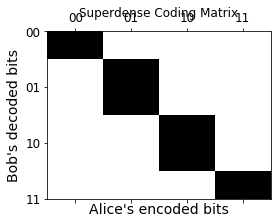

In [9]:
# Visualization

b00_sv = (Statevector.from_label('00')+Statevector.from_label('11'))/np.sqrt(2)
b01_sv = (Statevector.from_label('01')+Statevector.from_label('10'))/np.sqrt(2)
b10_sv = (Statevector.from_label('00')-Statevector.from_label('11'))/np.sqrt(2)
b11_sv = (Statevector.from_label('01')-Statevector.from_label('10'))/np.sqrt(2)
bell_states_sv = [b00_sv, b01_sv, b10_sv, b11_sv]
basis_states = ['00', '01', '10', '11']
bell_dict = dict(zip(basis_states, bell_states_sv))
enc_dec_mat = np.zeros((len(basis_states),len(basis_states)))
try:
    for state in basis_states:
        sv_checks = []
        qc = superdense_coding_circ(state)
        assert list(qc.count_ops()) != [], f" Bitstring {state}: Circuit cannot be empty"
        assert qc.count_ops()['measure'] <= 2, f" Bitstring {state}: Please remove extra measurements"
        assert qc.count_ops()['snapshot'] == 3, f" Bitstring {state}: Please do not add or remove snapshots"
        assert set(qc.count_ops().keys()).difference(basis_gates) == set(), f" Bitstring {state}: Only the following basic gates are allowed: {basis_gates}"
        assert all([type(gate[0]) == qiskit.circuit.measure.Measure for gate in qc.data[-2:len(qc.data)]]), f" Bitstring {state}: Measurement must be the last operation in a circuit."
        result = execute(qc.reverse_bits(),backend=QasmSimulator(), shots=1).result().get_counts().most_frequent()
        assert state == result, f" Bitstring {state}: Your encoding is not correct"
        enc_dec_mat[int(state,2), int(result,2)] = 1
        sv = execute(qc.reverse_bits(), backend=StatevectorSimulator()).result().data()['snapshots']['statevector']
        sv_checks.append(b00_sv.equiv(sv['1'][0]))
        sv_checks.append(bell_dict[state].equiv(sv['2'][0]))
        sv_checks.append(Statevector.from_label(state).equiv(sv['3'][0]))
    assert all(np.diag(enc_dec_mat) == np.ones(4)), "Your encoding is not correct"
    plt.matshow(enc_dec_mat, cmap='binary')
    plt.title('Superdense Coding Matrix')
    plt.xlabel("Alice's encoded bits", fontsize=14)
    plt.ylabel("Bob's decoded bits", fontsize=14)
    plt.xticks(ticks=range(4), labels=basis_states, fontsize=12)
    plt.yticks(ticks=range(4), labels=basis_states, fontsize=12)
    circ_check = all(sv_checks)
    assert circ_check, "Your circuit does not work for all bitstrings"

    print("success" if circ_check else "failed")
except AssertionError as e:
    print(f'Your code has an error:  {e.args[0]}')
    
except Exception as e:
    print(f'This error occured: {e.args[0]}')